# Predicting the Severity of Road Traffic Accidents

## Table of contents
* [Introduction: Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Problem

Traffic accidents are a significant source of deaths, injuries, property damage, and a major concern for public health and traffic safety. Accidents are also a major cause of traffic congestion and delay. Effective management of accident is crucial to mitigating accident impacts and improving traffic safety and transportation system efficiency. Accurate predictions of severity can provide crucial information for emergency responders to **evaluate the severity level of accidents, locate accident blackspots, estimate the potential impacts, and implement efficient accident management procedures**.

Model can be applied to predictions of accident severity which is an essential step in accident management process. By recognizing those key influences, this report can provide suggestive results for **government and local authorities** to take effective measures to reduce accident impacts and improve traffic safety.

## Data

Based on definition of our problem, factors that will be taken into consideration for our predictions are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Italian restaurants in the neighborhood, if any
* distance of neighborhood from city center

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data from CSV file

In [2]:
df = pd.read_csv('Data-Collisions.csv')

/home/dvasilyev/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
df.shape

(194673, 38)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

Let's see how many of each class is in our data set

In [6]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

136485 incidents ended with **property damage** and 58188 involved **injury**. Our dataset is **imbalanced**.

## Data visualization and pre-processing

### Review and fill up missing values first

#### We are going to keep only columns that have proper description and might be used for severity predictions

In [7]:
df = df[['SEVERITYCODE', 'ADDRTYPE', 'LOCATION', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',  
         'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'JUNCTIONTYPE', 
         'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 
         'PEDROWNOTGRNT', 'SPEEDING', 'ST_COLCODE', 'HITPARKEDCAR']]

#### Let's count number of Null values in each column

In [8]:
df.isnull().sum()

SEVERITYCODE           0
ADDRTYPE            1926
LOCATION            2677
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
JUNCTIONTYPE        6329
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
ST_COLCODE            18
HITPARKEDCAR           0
dtype: int64

#### All missing values are categorical type. Some missing values will be replaced with mode, another - with 'Unknown' status, the rest will be converted from categorical to numeric values

In [9]:
def nan_to_max_occ(item):
    df.loc[df[item].isnull(), [item]] = df[item].value_counts().idxmax()

In [10]:
def nan_to_unknown(item):    
    df.loc[df[item].isnull(), [item]] = 'Unknown'

In [11]:
def nan_to_numeric(item):
    df.loc[df[item].isnull(), item] = 0
    df.loc[df[item] == 'N', item] = 0
    df.loc[df[item] == 'Y', item] = 1

In [12]:
for item in ['ADDRTYPE', 'COLLISIONTYPE', 'ST_COLCODE']:
    nan_to_max_occ(item)

In [13]:
for item in ['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']:
    nan_to_unknown(item)

In [14]:
for item in ['INATTENTIONIND', 'SPEEDING', 'HITPARKEDCAR', 'PEDROWNOTGRNT']:
    nan_to_numeric(item)

In [15]:
df['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [16]:
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace=[np.nan, 'N', '0', 'Y', '1'], value=[0, 0, 0, 1, 1])

In [17]:
df['UNDERINFL'].value_counts()

0    185552
1      9121
Name: UNDERINFL, dtype: int64

In [18]:
df.isnull().sum()

SEVERITYCODE         0
ADDRTYPE             0
LOCATION          2677
COLLISIONTYPE        0
PERSONCOUNT          0
PEDCOUNT             0
PEDCYLCOUNT          0
VEHCOUNT             0
INCDATE              0
JUNCTIONTYPE         0
INATTENTIONIND       0
UNDERINFL            0
WEATHER              0
ROADCOND             0
LIGHTCOND            0
PEDROWNOTGRNT        0
SPEEDING             0
ST_COLCODE           0
HITPARKEDCAR         0
dtype: int64

In [19]:
df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0          1               0.705603
           2               0.294397
1          1               0.609473
           2               0.390527
Name: SEVERITYCODE, dtype: float64

In [20]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])

In [21]:
df.head()

,SEVERITYCODE,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR
0,2,Intersection,5TH AVE NE AND NE 103RD ST,Angles,2,0,0,2,2013-03-27 00:00:00+00:00,At Intersection (intersection related),0,0,Overcast,Wet,Daylight,0,0,10,0
1,1,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,0,0,2,2006-12-20 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0,11,0
2,1,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,0,0,3,2004-11-18 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0,32,0
3,1,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,0,0,3,2013-03-29 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0,23,0
4,2,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,Angles,2,0,0,2,2004-01-28 00:00:00+00:00,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,10,0


### Let's review outliers for numeric features 

#### Number of persons involved in the collision with severity type:

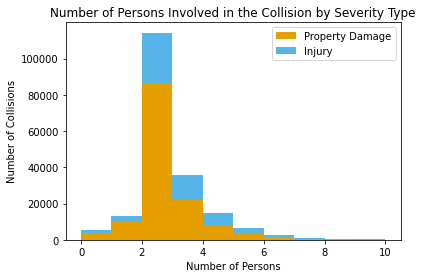

In [22]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PERSONCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PERSONCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 10], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Persons')
plt.ylabel('Number of Collisions')
plt.title('Number of Persons Involved in the Collision by Severity Type');

In [23]:
df.loc[df['PERSONCOUNT'] > 10, 'PERSONCOUNT']

93        16
639       11
966       12
1124      11
1650      17
          ..
185091    13
189316    34
190965    44
191624    12
191901    11
Name: PERSONCOUNT, Length: 237, dtype: int64

Let's assume that any value above 10 for 'Person Count' will be equal 10 to remove outliers.

In [24]:
df.loc[df['PERSONCOUNT'] > 10, 'PERSONCOUNT'] = 10

#### Number of pedestrians involved in the collision:

In [25]:
df['PEDCOUNT'].value_counts()

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

Let's convert it into 0 or 1 values, so either pedestrians were involved into collision or not.

In [26]:
df.loc[df['PEDCOUNT'] > 1, 'PEDCOUNT'] = 1

#### Number of bicycles involved in the collision:

In [27]:
df['PEDCYLCOUNT'].value_counts()

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

Same way let's convert it into 0 or 1 values, so either bicycles were involved into collision or not.

In [28]:
df.loc[df['PEDCYLCOUNT'] > 1, 'PEDCYLCOUNT'] = 1

#### Number of vehicles involved in the collision:

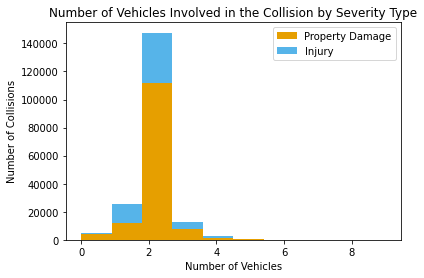

In [29]:
x1 = list(df[df['SEVERITYCODE'] == 1]['VEHCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['VEHCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 9], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Collisions')
plt.title('Number of Vehicles Involved in the Collision by Severity Type');

Let's assume that any value above 5 for 'Vehicle Count' will be equal 5 to remove outliers.

In [30]:
df.loc[df['VEHCOUNT'] > 5, 'VEHCOUNT'] = 5

### Extra features for out dataset

#### Reviewing Location column to see if collisions occured in the same place.

In [31]:
df['LOCATION'].value_counts()[:10]

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                          276
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                          271
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N                                265
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                                          254
6TH AVE AND JAMES ST                                                                    252
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST                                          239
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP                238
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST                                   231
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP              212
WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP    212
Name: LOCATION, dtype: int64

Let's add another column with number of collisions in that location and drop Location column

In [43]:
df['NUMCOLLOCATION'] = df.groupby('LOCATION')['SEVERITYCODE'].transform('size')
del df['LOCATION']

In [44]:
df.loc[df['NUMCOLLOCATION'].isnull(), 'NUMCOLLOCATION'] = 0

In [45]:
df['NUMCOLLOCATION'] = df['NUMCOLLOCATION'].astype(np.int64)

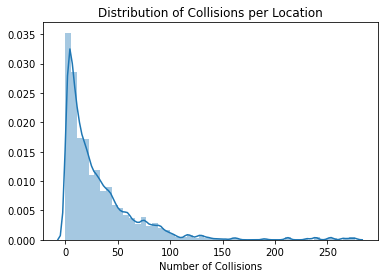

In [46]:
ax = sns.distplot(df['NUMCOLLOCATION'])
ax.set(xlabel = 'Number of Collisions', title='Distribution of Collisions per Location')
plt.show()

In [47]:
df.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,NUMCOLLOCATION
0,2,Intersection,Angles,2,0,0,2,2013-03-27 00:00:00+00:00,At Intersection (intersection related),0,0,Overcast,Wet,Daylight,0,0,10,0,31
1,1,Block,Sideswipe,2,0,0,2,2006-12-20 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0,11,0,190
2,1,Block,Parked Car,4,0,0,3,2004-11-18 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0,32,0,34
3,1,Block,Other,3,0,0,3,2013-03-29 00:00:00+00:00,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0,23,0,27
4,2,Intersection,Angles,2,0,0,2,2004-01-28 00:00:00+00:00,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0,10,0,28


In [52]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      20172
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [53]:
df['ST_COLCODE'].value_counts()

32    27630
10    23427
14    16883
32    16809
10    11247
      ...  
49        1
87        1
85        1
60        1
43        1
Name: ST_COLCODE, Length: 115, dtype: int64